In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from xgboost import XGBClassifier


pd.set_option('display.max_columns', None)

random_state = 42

# Funciones

In [ ]:
class FrequencySamplerImputerNumeric(BaseEstimator, TransformerMixin):
    """
    Imputa NaNs en columnas numéricas muestreando aleatoriamente valores observados
    según su frecuencia por columna.
    """
    def __init__(self, random_state=42):
        self.random_state = random_state

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X).copy()
        self.value_probs_ = {}

        for col in X_df.columns:
            s = pd.to_numeric(X_df[col], errors="coerce")
            vc = s.dropna().value_counts(normalize=True)

            # Si no hay valores válidos, guardamos None
            if vc.empty:
                self.value_probs_[col] = None
            else:
                self.value_probs_[col] = (vc.index.to_numpy(), vc.to_numpy())

        return self

    def transform(self, X):
        rng = np.random.default_rng(self.random_state)
        X_df = pd.DataFrame(X).copy()

        for col in X_df.columns:
            s = pd.to_numeric(X_df[col], errors="coerce")
            mask = s.isna()

            vp = self.value_probs_.get(col)
            if mask.any():
                if vp is None:
                    # fallback: si todo era NaN en fit, imputar 0.0
                    s.loc[mask] = 0.0
                else:
                    values, probs = vp
                    s.loc[mask] = rng.choice(values, size=int(mask.sum()), p=probs)

            X_df[col] = s

        return X_df.to_numpy(dtype=float)

# Columnas descartadas
Dado el EDA, se muestran las razones por las cuales se descartaron las siguientes variables:

### Target leakage
- SHORT_DESC: Leakage -> Relación 1-1 con CLASS

### IDs
- P_ID: Identificador único
- TAX_MAP: Identificador/código casi único

### Redundancia
- SHORT_DESC 1: Redundante con LEVY_CODE_1

### Dirección exacta / alta cardinalidad / PII (riesgo + no generaliza)
- FORMATED_ADDRESS: Dirección completa (alta cardinalidad, PII).
- STREET: Nombre de calle (alta cardinalidad, PII).
- SUFFIX: Parte de dirección; redundante con STREET (Cramér’s V alto) y poca utilidad.
- FREE_LINE_2: Texto libre de mailing (alta cardinalidad, PII).
- FIRST_NAME: PII (nombre).
- LAST_NAME: PII (apellido).
- COMPANY: PII/alta cardinalidad

### Mailing address
- CIVIC 1
- STREET 1
- S_SUFFIX
- CITY 1
- STATE
- ZIP_POSTAL 1

### Unidades
- unit: Alta cardinalidad
- UNIT: Redundante/relacionada con unit

### Geografía en formato string / derivaciones no usadas
- Property_Location: Se usa solo para extraer lat/lon
- geo_cell: Demasiado granular y poco aporte



# Columnas seleccionadas

In [ ]:
target = "CLASS"

num_features_final = ["TOTAL_ASSMT", "TOTAL_TAXES", "TOTAL_EXEMPT", "lat", "lon", "CIVIC 1"]
cat_features_final = ["LEVY_CODE_1", "geo_cluster", ]
zip_feature = ["ZIP_POSTAL"]

features_final = num_features_final + cat_features_final + zip_feature

In [ ]:
DATA_PATH = "../data/2024_Property_Tax_Roll.csv"
df_ = pd.read_csv(DATA_PATH)

coords = df_["Property_Location"].str.extract(r"POINT\s*\(\s*([-\d\.]+)\s+([-\d\.]+)\s*\)")
df_.loc[:,"lon"] = pd.to_numeric(coords[0], errors="coerce")
df_.loc[:,"lat"] = pd.to_numeric(coords[1], errors="coerce")

valid = df_[["lat", "lon"]].dropna()
kmeans = KMeans(n_clusters=10, random_state=random_state)
df_.loc[valid.index, "geo_cluster"] = kmeans.fit_predict(valid)

df_["geo_cluster"] = df_["geo_cluster"].astype("Int64").astype(str)


In [ ]:
df_model = df_.dropna(subset=[target]).copy()

X = df_model[features_final].copy()
y = df_model[target].astype("Int64").astype(str)

X.shape, y.shape

((44033, 9), (44033,))

In [ ]:
df_model[features_final].isna().sum().sort_values(ascending=False)

ZIP_POSTAL      1436
CIVIC             95
TOTAL_ASSMT        0
TOTAL_TAXES        0
TOTAL_EXEMPT       0
lon                0
lat                0
LEVY_CODE_1        0
geo_cluster        0
dtype: int64

In [ ]:
(X.isnull().mean().mul(100).sort_values(ascending=False))


ZIP_POSTAL      3.261190
CIVIC           0.215747
TOTAL_ASSMT     0.000000
TOTAL_TAXES     0.000000
TOTAL_EXEMPT    0.000000
lon             0.000000
lat             0.000000
LEVY_CODE_1     0.000000
geo_cluster     0.000000
dtype: float64

# Separación train_test

In [ ]:
y_int = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y_int, test_size=0.2, random_state=random_state, stratify=y_int)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((35226, 9), (8807, 9), (35226,), (8807,))

In [ ]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

le.classes_

array([ 1,  2,  3,  4,  5,  6,  7, 10, 12, 13, 14, 23, 24, 33, 70, 71, 72,
       73, 74, 75, 76, 78, 79, 80, 82, 83, 84])

In [ ]:
# Distribución de clases (proporciones) para confirmar estratificación
dist_train = y_train.value_counts(normalize=True).sort_index()
dist_test  = y_test.value_counts(normalize=True).sort_index()

dist_train.head(), dist_test.head()


(CLASS
 1    0.334412
 2    0.317691
 3    0.011696
 4    0.016408
 5    0.000596
 Name: proportion, dtype: float64,
 CLASS
 1    0.334393
 2    0.317702
 3    0.011695
 4    0.016464
 5    0.000568
 Name: proportion, dtype: float64)

## Preprocesamiento

In [ ]:
# Pipelines
numeric_pipe_scaled = Pipeline([
    ("imp_freq", FrequencySamplerImputerNumeric(random_state=random_state)),
    ("scaler", StandardScaler()),
])

numeric_pipe_raw = Pipeline([
    ("imp_freq", FrequencySamplerImputerNumeric(random_state=random_state)),
])

cat_pipe = Pipeline([
    ("oh", OneHotEncoder(handle_unknown="ignore"))
])

zip_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="constant", fill_value="MISSING")),
    ("oh", OneHotEncoder(handle_unknown="ignore"))
])

# Preprocesador final
# Modelos que necesitan estandarización
preprocess_scaled = ColumnTransformer([
    ("num", numeric_pipe_scaled, num_features_final),
    ("cat", cat_pipe,          cat_features_final),
    ("zip", zip_pipe,          zip_feature),
], remainder="drop")

# Modelos que no necesitan estandarización
preprocess_raw = ColumnTransformer([
    ("num", numeric_pipe_raw,  num_features_final),
    ("cat", cat_pipe,          cat_features_final),
    ("zip", zip_pipe,          zip_feature),
], remainder="drop")



# Selección de modelo
- Se usarán 6 modelos para determinar cuál arroja mejores resultados
  - LogisticRegression
  - SGDClassifier
  - RandomForestClassifier 
  - GradientBoostingClassifier
  - AdaBoostClassifier
  - XGBClassifier

In [ ]:
# Se guardan ids

id_cols = ["P_ID", "TAX_MAP"]
ids_train = df_model.loc[X_train.index, id_cols].copy()
ids_test  = df_model.loc[X_test.index, id_cols].copy()

In [ ]:
# Transformando features a dense 
to_dense = FunctionTransformer(
    lambda x: x.toarray() if hasattr(x, "toarray") else x,
    accept_sparse=True
)

In [ ]:
models = {
    "LR": LogisticRegression(
        solver="saga",
        max_iter=5000,
        class_weight="balanced",
        random_state=random_state
    ),

    "SGD": SGDClassifier(
        loss="log_loss",
        alpha=1e-4,
        max_iter=3000,
        tol=1e-3,
        class_weight="balanced",
        random_state=random_state
    ),

    "RF": RandomForestClassifier(
        n_estimators=500,
        class_weight="balanced_subsample",
        random_state=random_state
    ),

    "GradientBoosting": GradientBoostingClassifier(
        n_estimators = 100, 
        learning_rate= 0.03,
        max_depth = 3, 
        random_state=random_state
        ),

    "AdaBoost": AdaBoostClassifier(
        n_estimators=100, 
        learning_rate=0.03, 
        random_state=random_state
        ),

    "XGBoost": XGBClassifier(
        objective="multi:softprob",
        eval_metric="mlogloss",
        num_class=len(le.classes_),
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=random_state,
    )
}


# Piplines

In [ ]:
pipelines = {}

pipelines["LR"] = Pipeline([
    ("pre", preprocess_scaled),
    ("model", models["LR"])
])

pipelines["SGD"] = Pipeline([
    ("pre", preprocess_scaled),
    ("model", models["SGD"])
])

pipelines["RF"] = Pipeline([
    ("pre", preprocess_raw),
    ("model", models["RF"])
])

pipelines["GradientBoosting"] = Pipeline([
    ("pre", preprocess_raw),
    ("dense", to_dense),
    ("model", models["GradientBoosting"])
])

pipelines["AdaBoost"] = Pipeline([
    ("pre", preprocess_raw),
    ("dense", to_dense),
    ("model", models["AdaBoost"])
])

pipelines["XGBoost"] = Pipeline([
        ("pre", preprocess_raw),
        ("model", models["XGBoost"])
    ])

## Selección mejor modelo

In [ ]:
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=random_state)

results = []
for name, pipe in pipelines.items():
    print(name)
    scores = cross_validate(
        pipe,
        X_train,
        y_train_enc,
        cv=cv,
        scoring={"acc": "accuracy", "f1m": "f1_macro"},
        return_train_score=False
    )
    results.append({
        "model": name,
        "acc_mean": float(np.mean(scores["test_acc"])),
        "acc_std": float(np.std(scores["test_acc"])),
        "f1_macro_mean": float(np.mean(scores["test_f1m"])),
        "f1_macro_std": float(np.std(scores["test_f1m"])),
    })

result_cv = pd.DataFrame(results).sort_values("f1_macro_mean", ascending=False).reset_index(drop=True)
result_cv

LR


/home/juanorion/.pyenv/versions/.env_tributi/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/juanorion/.pyenv/versions/.env_tributi/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


SGD
RF
GradientBoosting
AdaBoost
XGBoost


,model,acc_mean,acc_std,f1_macro_mean,f1_macro_std
0,RF,0.800460,0.002583,0.552705,0.031613
1,XGBoost,0.815988,0.002555,0.538355,0.014838
2,GradientBoosting,0.771277,0.003719,0.479373,0.008755
3,LR,0.601147,0.003804,0.342312,0.001953
4,SGD,0.561460,0.002668,0.265516,0.004546
5,AdaBoost,0.430847,0.001845,0.051926,0.001197


## Entrenamiento mejor modelo.
- Se escoge RandonForest

In [ ]:
best_name = result_cv["model"].values[0]
best_pipe = pipelines[best_name]

best_pipe.fit(X_train, y_train_enc)


,steps,"[('pre', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Predicción

In [ ]:
y_pred_enc = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)

# volver a clases originales
y_pred = le.inverse_transform(y_pred_enc)
y_true = y_test

## Métricas

In [ ]:
acc = accuracy_score(y_true, y_pred)
acc

0.8296809356193937

/home/juanorion/.pyenv/versions/.env_tributi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/juanorion/.pyenv/versions/.env_tributi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/juanorion/.pyenv/versions/.env_tributi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(

              precision    recall  f1-score   support

           1     0.8253    0.8567    0.8407      2945
           2     0.8459    0.8277    0.8367      2798
           3     0.7200    0.6990    0.7094       103
           4     0.6271    0.5103    0.5627       145
           5     0.0000    0.0000    0.0000         5
           6     0.5824    0.6947    0.6336       285
           7     0.5529    0.4563    0.5000       103
          10     0.3333    0.1667    0.2222         6
          12     1.0000    1.0000    1.0000       124
          13     0.9934    0.9869    0.9901       610
          14     0.8452    0.8534    0.8493       307
          23     0.9436    0.8875    0.9147       773
          24     0.9125    0.8588    0.8848        85
          70     0.0000    0.0000    0.0000         3
          71     0.6140    0.4861    0.5426        72
          72     0.5732    0.5165    0.5434        91
          73     0.0000    0.0000    0.0000         1
          74     1.0000    

Text(0.5, 1.0, 'Matriz de confusión')

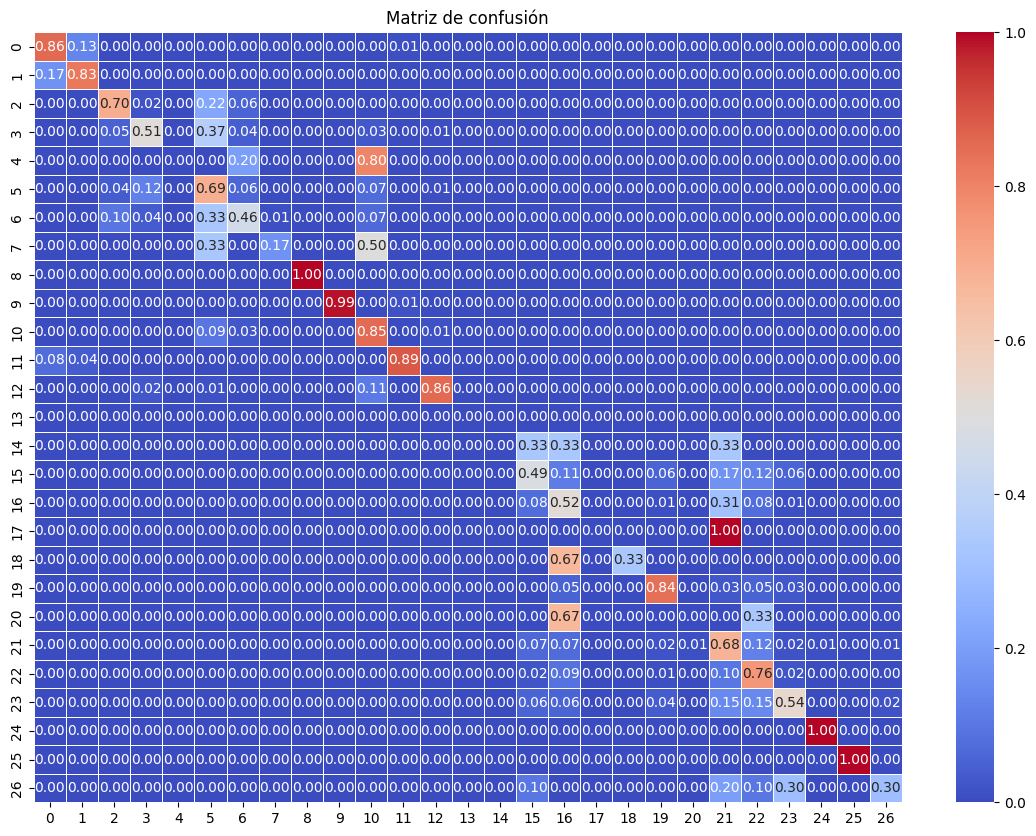

In [ ]:
labels = le.classes_ 
cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")
cr = classification_report(y_true, y_pred, digits=4)
print(cr)
plt.figure(figsize=(14, 10))
sns.heatmap(cm_norm, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5 )
plt.title('Matriz de confusión')


### Probabilidad asignada a cada clase y top 10 menor confianza
- p_true: probabilidad que el modelo le da a la clase real

In [ ]:
# Probabilidad
p_true = y_proba[np.arange(len(y_test_enc)), y_test_enc]

# top10
top_10 = np.argsort(p_true)[:10]
id_top10 = X_test.index[top_10]

In [ ]:
df_top10 = pd.DataFrame({
    "p_true": p_true[top_10],
    "y_true": y_true.loc[id_top10].values,
    "y_pred": y_pred[top_10],
    "max_proba": y_proba[top_10].max(axis=1),
    "pred_class": le.inverse_transform(y_proba[top_10].argmax(axis=1)),
}, index=id_top10).sort_values("p_true")
df_top10 = df_top10.join(ids_test.loc[df_top10.index])

df_top10

,p_true,y_true,y_pred,max_proba,pred_class,P_ID,TAX_MAP
12057,0.000,76,79,0.698,79,6378.0,020-0372-REVO
27888,0.000,14,6,0.620,6,35274.0,091-0583-0000
7880,0.000,10,6,0.402,6,4566.0,015-0467-0000
10493,0.000,70,71,0.324,71,9593.0,030-0452-0000
25107,0.000,5,14,0.786,14,29349.0,077-0044-0000
39744,0.000,24,4,0.542,4,70863.0,116-0561-0005
16612,0.000,79,71,0.544,71,14456.0,043-0018-0000
27637,0.002,7,6,0.480,6,30734.0,080-0449-0000
466,0.002,1,2,0.966,2,8208.0,028-0022-0000
15938,0.002,4,6,0.724,6,3548.0,012-0473-0000
